# Project 1: The Strategic Product Analytics Showcase
## Notebook 2: Investigating the Drop-off with Funnel Analysis

### Objective

In the previous notebook, we diagnosed a critical business problem: **monthly user retention plummets to a mere 2-6% after the first month**. We concluded this is a fundamental "Failure to Activate," meaning users aren't experiencing the product's core value.

This notebook moves from diagnosis to **investigation**. Our goal is to test that "Failure to Activate" hypothesis by analyzing the core e-commerce conversion funnel. By mapping the user journey from viewing a product to making a purchase, we can pinpoint the *exact stage* where the vast majority of users drop off.

Our defined funnel is:
1.  **View Product:** The user views an item.
2.  **Add to Cart:** The user adds an item to their shopping cart.
3.  **Purchase:** The user completes the purchase.

In [1]:
# --- 1. Setup & Imports ---
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Set a professional-looking template for Plotly for high-quality visuals
pio.templates.default = "plotly_white"

print("Libraries imported successfully.")

Libraries imported successfully.


### 2. Data Loading

We'll reload the same dataset used in Notebook 1 to ensure our analysis is perfectly consistent. We will again sample the last 1 million events to maintain a manageable size for this interactive analysis.

In [2]:
# --- 2. Load and Inspect the Data ---
DATA_PATH = '../data/events.csv'

# Load the dataset
try:
    df_events = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Total events: {len(df_events)}")
except FileNotFoundError:
    print(f"Error: {DATA_PATH} not found.")
    df_events = pd.DataFrame()

if not df_events.empty:
    # Work with a sample of the most recent 1M events
    df_events = df_events.tail(1000000).copy()
    print(f"\nWorking with a sample of the most recent {len(df_events):,} events.")

Dataset loaded successfully. Total events: 885129

Working with a sample of the most recent 885,129 events.


### 3. Data Preparation for Funnel Analysis

To build the funnel, we need to determine how many unique user sessions completed each step. A `user_session` represents a single visit, which is the correct scope for a conversion funnel analysis.

We will:
1.  Filter the events to include only our defined funnel steps: `view`, `cart`, and `purchase`.
2.  Use `pd.crosstab` to create a summary table. This is an efficient way to count the occurrences of each event type for every unique `user_session`.
3.  Convert the counts into boolean flags (True/False) to indicate whether a session included a specific event type at least once.

In [3]:
# --- 3. Prepare Data for Funnel ---
if not df_events.empty:
    # Define the sequence of events in our funnel
    funnel_steps = ['view', 'cart', 'purchase']
    
    # Filter for only the events that are part of our funnel
    df_funnel = df_events[df_events['event_type'].isin(funnel_steps)].copy()
    
    # Create a summary table counting event types per user session
    session_event_counts = pd.crosstab(df_funnel['user_session'], df_funnel['event_type'])
    
    print("Raw event counts per session (sample):")
    display(session_event_counts.head())
    
    # Convert counts to boolean flags (did the event happen at least once?)
    funnel_data = (session_event_counts > 0).reset_index()
    
    # Ensure all funnel step columns exist, filling missing ones with False
    for step in funnel_steps:
        if step not in funnel_data.columns:
            funnel_data[step] = False

    print("\nBoolean flags for funnel events per session (sample):")
    display(funnel_data.head())

Raw event counts per session (sample):


event_type,cart,purchase,view
user_session,,,
000AMhYaQu,0,0,1
000c34fa-991f-442a-8e07-8c472269bec6,0,0,1
001HttdHUk,0,0,1
001P7lK0Pt,0,0,2
001RxUtFJa,0,0,1



Boolean flags for funnel events per session (sample):


event_type,user_session,cart,purchase,view
0,000AMhYaQu,False,False,True
1,000c34fa-991f-442a-8e07-8c472269bec6,False,False,True
2,001HttdHUk,False,False,True
3,001P7lK0Pt,False,False,True
4,001RxUtFJa,False,False,True


### 4. Calculating Funnel Conversion

Now we will calculate the number of sessions that reached each stage of the funnel. The logic must be sequential to be meaningful:
- **Step 1 (View):** All sessions containing at least one `view` event.
- **Step 2 (Cart):** Of those who viewed, how many *also* had a `cart` event in the same session?
- **Step 3 (Purchase):** Of those who added to cart, how many *also* had a `purchase` event in the same session?

This methodology isolates the conversion rate between each specific step.

In [4]:
# --- 4. Calculate Funnel Numbers ---
if 'funnel_data' in locals():
    # Step 1: Sessions with a 'view'
    view_sessions = funnel_data[funnel_data['view']]
    n_view = len(view_sessions)

    # Step 2: Of those who viewed, how many added to cart?
    cart_sessions = view_sessions[view_sessions['cart']]
    n_cart = len(cart_sessions)

    # Step 3: Of those who added to cart, how many purchased?
    purchase_sessions = cart_sessions[cart_sessions['purchase']]
    n_purchase = len(purchase_sessions)

    # Compile the results into a clean DataFrame
    funnel_summary = pd.DataFrame({
        'Step': ['View', 'Cart', 'Purchase'],
        'Count': [n_view, n_cart, n_purchase]
    })
    
    # Calculate conversion rates for analysis
    funnel_summary['Conversion from Previous Step'] = (funnel_summary['Count'] / funnel_summary['Count'].shift(1)).fillna(1.0)
    funnel_summary['Overall Conversion from View'] = (funnel_summary['Count'] / n_view).fillna(1.0)

    print("Funnel Conversion Summary:")
    display(funnel_summary.style.format({
        'Count': '{:,.0f}',
        'Conversion from Previous Step': '{:.2%}',
        'Overall Conversion from View': '{:.2%}'
    }))

Funnel Conversion Summary:


,Step,Count,Conversion from Previous Step,Overall Conversion from View
0,View,"488,360",100.00%,100.00%
1,Cart,"41,256",8.45%,8.45%
2,Purchase,"20,754",50.31%,4.25%


### 5. Visualizing the Funnel

A funnel chart is the most effective way to communicate these findings to stakeholders. It provides an intuitive visualization of the drop-off at each stage. We will use `plotly` to create a professional and interactive chart that clearly tells the story.

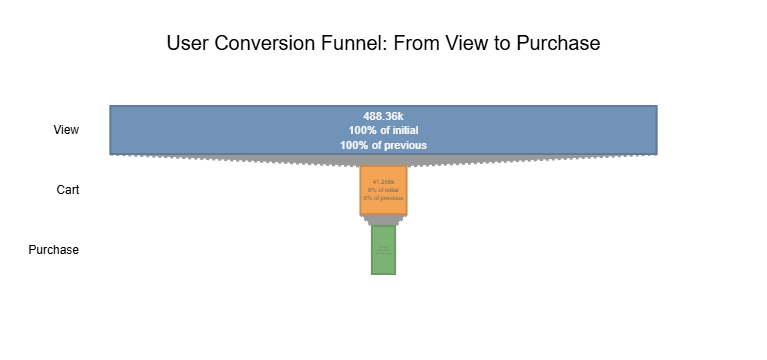

In [5]:
# --- 5. Visualize the Funnel ---
if 'funnel_summary' in locals():
    fig = go.Figure(go.Funnel(
        y = funnel_summary['Step'],
        x = funnel_summary['Count'],
        textposition = "inside",
        textinfo = "value+percent initial+percent previous",
        opacity = 0.8,
        marker = {"color": ["#4E79A7", "#F28E2B", "#59A14F"],
                  "line": {"width": [2, 2, 2], "color": ["#3B597F", "#C27122", "#47813F"]}},
        connector = {"line": {"color": "grey", "dash": "dot", "width": 3}}
    ))

    fig.update_layout(
        title={
            'text': "User Conversion Funnel: From View to Purchase",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 20}
        },
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show(renderer="jupyterlab+png")

### 6. Investigation Findings and Next Steps

**Analysis:**
The funnel chart provides a stark and immediate answer to our investigation, validating our "Failure to Activate" hypothesis from Notebook 1. The data reveals two very different stories at each stage of the funnel.

1.  **The "Discovery to Consideration" Bottleneck:** The primary reason for our low retention is immediately obvious. Of all the user sessions that view a product, **only 8.4% proceed to add an item to their cart**. This means over 91% of user interest evaporates at this single step. This is the main leakage point in our entire user journey.

2.  **High-Intent "Consideration to Purchase" Conversion:** In stark contrast, the conversion from `Cart` to `Purchase` is surprisingly strong at **50.3%**. This is a crucial insight: if we can get a user to demonstrate high intent by adding an item to their cart, they have a good chance of completing the purchase.

**Conclusion:**
Our investigation successfully pinpoints the root cause of the catastrophic 2-6% retention we diagnosed. The problem is not that users are abandoning their carts in large numbers; **the core problem is that the vast majority of users never even begin the purchasing process.** They look at products but fail to take the crucial next step of adding to the cart, which is the true start of the activation journey.

**Next Steps:**
We've established a clear chain of logic:
- Low retention is caused by a fundamental activation failure.
- This activation failure is caused by a massive 91.6% drop-off between viewing a product and adding it to a cart.

The final, critical question is: **what separates the 8.4% of sessions that succeed from the 91.6% that fail?** What behaviors or user characteristics are predictive of a user successfully starting their cart?

Our next notebook, **`03_Insight_Interpretable_Modeling.ipynb`**, will build a model to answer this question, giving us the final insight needed to design a powerful, data-driven solution.